# Introduction to Probabilistic Graphical Models Practical Session 2

Instructions: The codes should be written in Python and no scanned papers will be accepted. Groups of 2 people are allowed. Put all your files (code and report – could be a single notebook file) in a zip file and submit it through moodle before October 29 2019, 23:50. Late submissions will not be accepted.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation

In [2]:
# All plot functions are included here
def plot_ellipses(A, mu,col):
    N = 36
    th = np.arange(0, 2 * np.pi + np.pi / N, np.pi / N)
    X = np.array([np.cos(th), np.sin(th)])
    
    Y = np.dot(A, X)
    ln = plt.Line2D(mu[0] + Y[0,:], mu[1] + Y[1,:], c=col, linewidth=2)
    return ln

def plot(x,mu, sigma, true=False):
    plt.figure(figsize=(15,8))
    plt.rc('text', usetex=False)
    if true:
        plt.title("Contours of the true Gaussians")
    else:
        plt.title("Contours of the estimated Gaussians")
    plt.grid()
    ax=plt.gca()

    for i in range(K):
        A = np.linalg.cholesky(sigma[i])
        x_plot = plt.plot(x[i][:,0],x[i][:,1],'.',color=color_list[i],label="Gaussienne n°%d"%i)
        mean_plot = plt.plot(mu[i][0],mu[i][1],'^k',markersize=15)
        ax.add_line(plot_ellipses(A,mu[i],"k"))

def plot_comparison(x,true_mu,true_sigma,mu,sigma):
    plt.figure(figsize=(15,8))
    plt.title("Contours of the estimated vs true Gaussians")
    plt.grid()
    ax=plt.gca()

    for i in range(K):
        true_A = np.linalg.cholesky(true_sigma[i])
        estimated_A = np.linalg.cholesky(sigma[i])
        x_plot = plt.plot(x[i][:,0],x[i][:,1],'.',color=color_list[i])
        true_mean_plot = plt.plot(true_mu[i][0],true_mu[i][1],'^k',mec="g",mfc=color_list[i], markersize=20)
        estimated_mean_plot = plt.plot(mu[i][0],mu[i][1],'^',mec=color_list[i],mfc='black',markersize=15)
        ax.add_line(plot_ellipses(true_A,true_mu[i],color_list[i]))
        ax.add_line(plot_ellipses(estimated_A,mu[i],'k'))
    plt.legend()
    plt.show()

## EM for GMMs

### Question 1

![Q1](image_Q1.png)

In [3]:
def log_sum_exp(v, axis=0):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

def log_det(A):
    diag = np.diag(np.linalg.cholesky(A))
    return 2 * np.sum(np.log(diag))

def comp_li(pi_i,x,mu_i,sigma_i):
    d=len(mu_i)
    li= np.log(pi_i) - d *np.log(2 *np.pi) /2 - log_det(sigma_i)/2 - (x-mu_i).T@np.linalg.inv(sigma_i)@(x-mu_i)/2
    return li
        
def comp_gamma_i(pi,x,mu,sigma,i):
    K = len(pi)
    v = np.zeros(K)

    for k in range(K):
        v[k] = comp_li(pi[k],x, mu[k], sigma[k])
    return np.exp(v[i] - log_sum_exp(v))

![Q2](image_Q2.png)

### Question 3

![Q3_1](image_Q3_1.png)

#### 1_

In [15]:
#Parameters
N=1000
K=3
true_pi= np.array([0.1,0.2,0.5])
true_mu=np.array([[0,0],[1,2],[2,0]])
true_sigma= np.array([[[1.00, -0.25], [-0.25, 0.50]],[[0.50, 0.25],[0.25, 0.50]],[[0.50, -0.25],[ -0.25, 1]]])

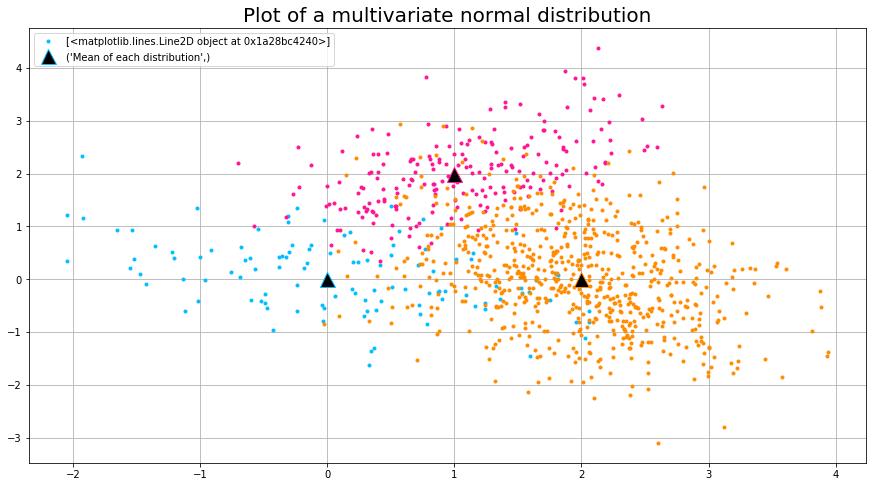

In [16]:
#Nb of values -n- in each distributions
list_N=np.random.multinomial(N, true_pi)

#list_x is a list of lists containing each distributions
list_x=[]
for i in range(K):
    list_x.append(np.random.multivariate_normal(true_mu[i], true_sigma[i], list_N[i]))
    
#X is the jointure of all the lists in x_list in one list 
X=np.vstack(list_x)

#First simple plot to see data
plt.figure(figsize=(15,8))
plt.grid()
color_list=["deepskyblue","deeppink","darkorange","forestgreen","blueviolet"] #funky color, because we like it

for i in range(K):
    x_plot = plt.plot(list_x[i][:,0],list_x[i][:,1],'.',color=color_list[i],label="Gaussienne n°%d"%i)
    mean_plot = plt.plot(true_mu[i,0],true_mu[i,1],'^k',markersize=15,mec = color_list[i])
    
plt.legend([(mean_plot),("Mean of each distribution",)])
plt.title("Plot of a multivariate normal distribution", fontsize="20")
plt.show()

#### 2_

In [17]:
## ALGORITHM EM 
def log_likelihood(x,gamma, pi, mu, sigma):
    log_like = 0
    for n in range(N):
        for k in range(K):
            log_like += gamma[n,k] * comp_li(pi[k],x[n], mu[k], sigma[k])
    return log_like

def EM(x,number_iteration, pi, mu, sigma, likelihood=False):
    likelihood_array = []
    plot_each=number_iteration//3
    for i in range(number_iteration):
        
        # E step 
        for n in range(N):
            for k in range(K):
                gamma[n,k] = comp_gamma_i(pi,x[n],mu,sigma,k)
                
        # Likelihood
        if likelihood:
            likelihood_array.append(log_likelihood(x,gamma, pi, mu, sigma))
            
        # M step 
        for k in range(K):
            mu[k] = np.zeros(len(mu[0]))
            for n in range(N):
                mu[k] += gamma[n,k] * x[n]
            mu[k] /= np.sum(gamma[:,k])
        sigma = np.zeros((K, 2, 2))
        for k in range(K):
            for n in range(N):
                A = np.reshape(x[n] - mu[k], (2,1))
                sigma[k] += gamma[n,k] * np.dot(A, A.T)
            sigma[k] /= np.sum(gamma[:,k])
            
        # PI
        for k in range(K):
            pi[k] = np.average(gamma[:,k])
        if i%plot_each==0:
            plot(list_x,mu,sigma)
        
    return pi, mu, sigma, likelihood_array

![Q3_2](image_Q3_2.png)

##### 2_a

In [18]:
#Initial parameters RANDOM
pi = np.random.rand(K)
pi = pi / np.sum(pi)

mu = []
sigma = []
for i in range(K):
    mu.append(np.random.randint(-1,5,2)) # for instance 
    A = np.random.rand(2,2)
    sigma.append(list(A.dot(A.T)))
        
gamma = np.zeros((N, K))

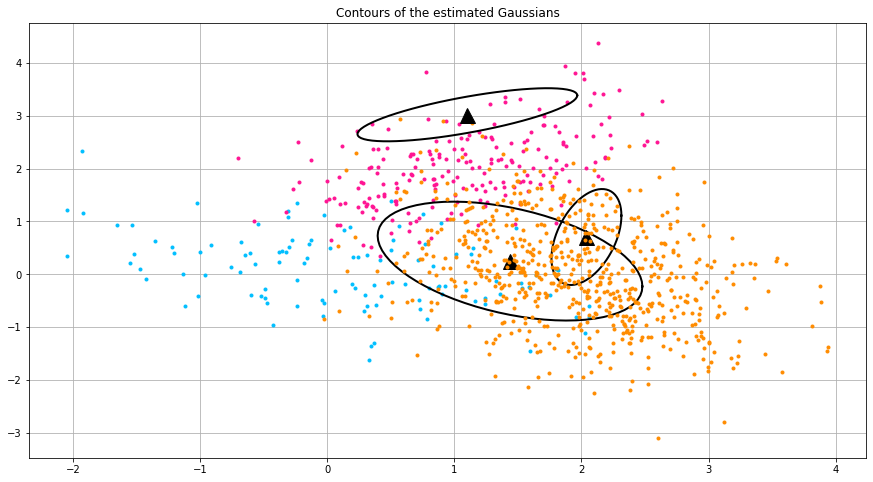

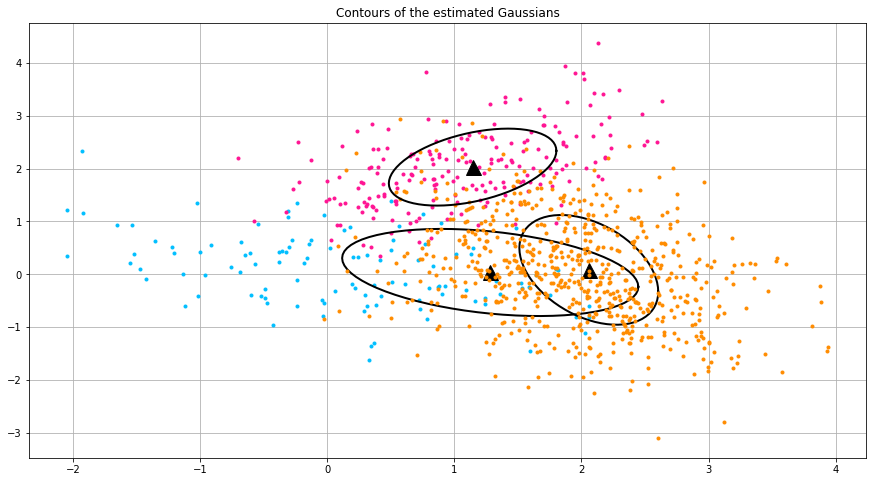

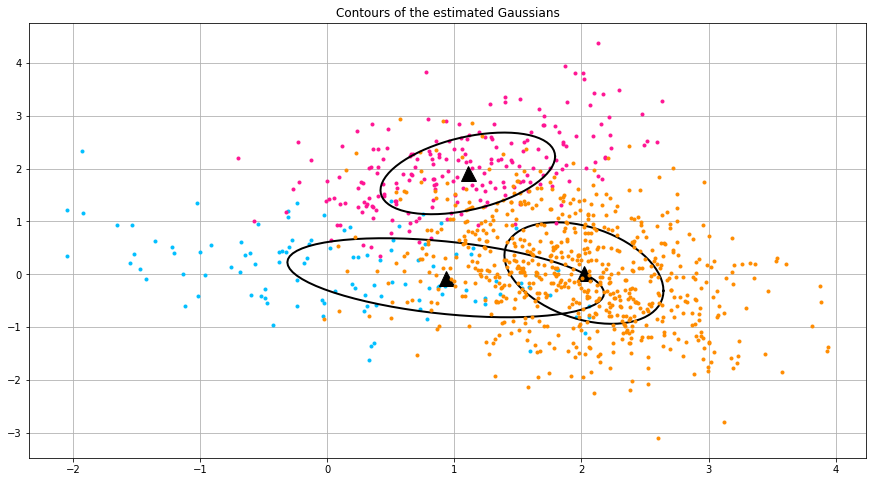

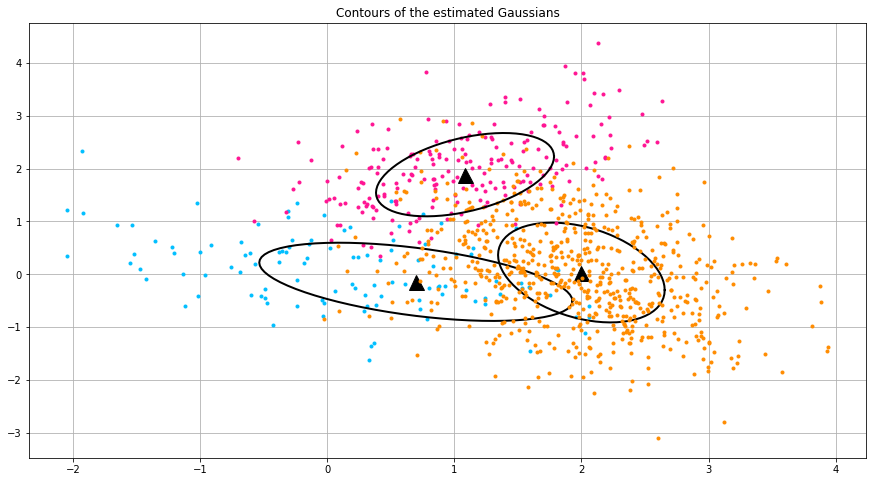

In [19]:
pi, mu, sigma, likelihood_array = EM(X,100, pi, mu, sigma,likelihood=True)

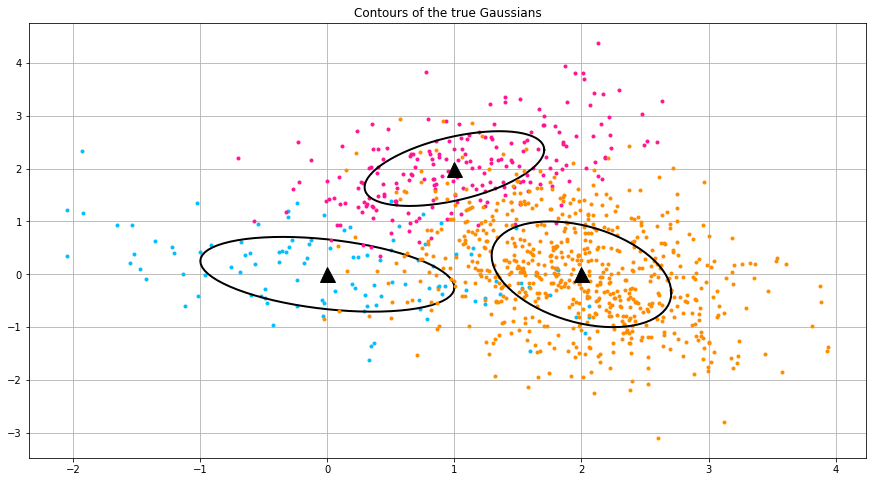

In [20]:
plot(list_x,true_mu,true_sigma,True)

##### 2_b

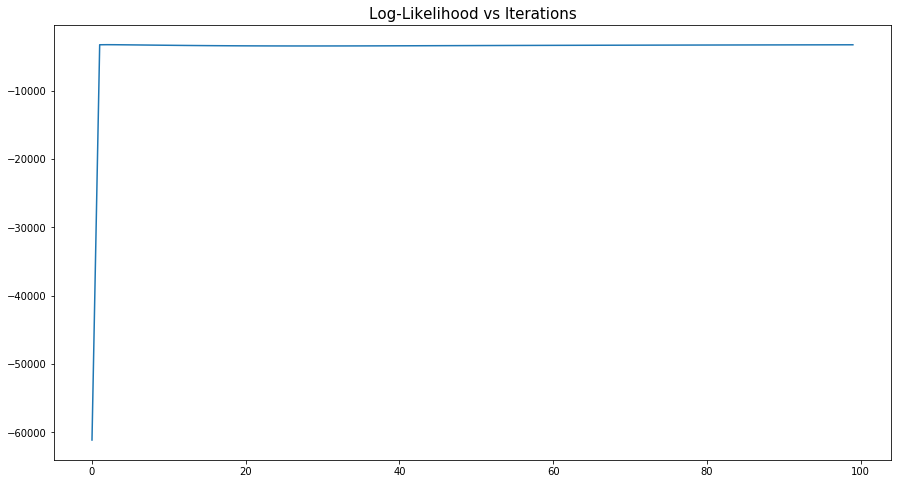

In [21]:
plt.figure(figsize=(15,8))
plt.title("Log-Likelihood vs Iterations", fontsize=15)
plt.plot(likelihood_array)
plt.show()

No handles with labels found to put in legend.


In black: estimated gaussians
In color: real gaussians


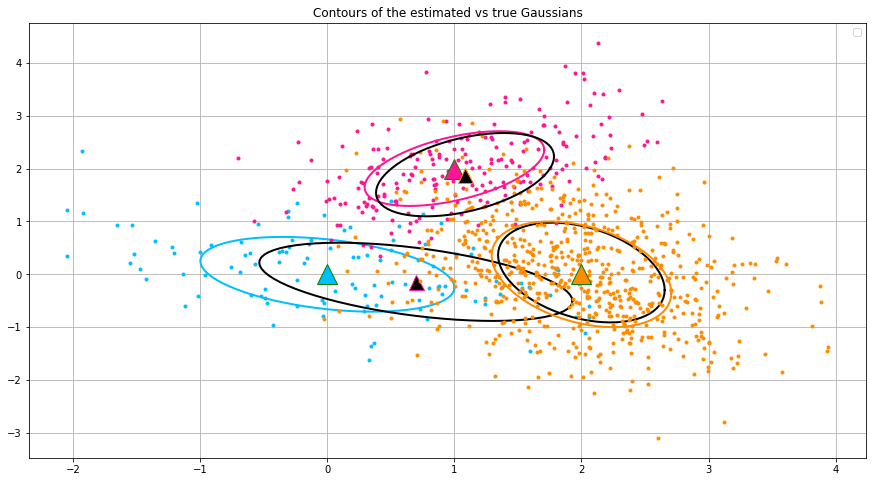

In [22]:
print("In black: estimated gaussians\nIn color: real gaussians")
plot_comparison(list_x,true_mu,true_sigma,mu, sigma)

##### 2_c

It seems that initialisation is crucial in EM. Indeed, during the lab we found out that if the mu$_i$'s were initialised too closely the clustering wouldn't work properly. A first idea would be to initialize them not next to each others. 
Biernacki et al. (2003) proposed random Search/Run/Select initialization strategies for Small EM and SEM